#Evaluation - id12041022

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
#start_time = '2012-02-01 00:00:00'
start_time = '2013-01-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

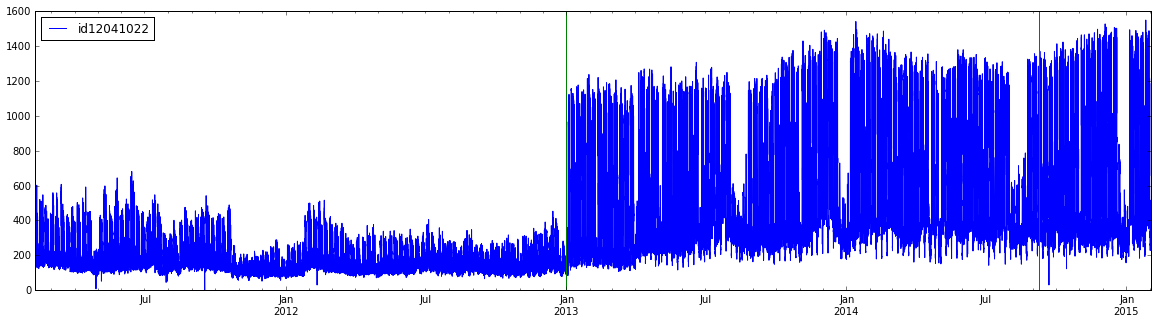

In [4]:
f = original_data[["id12041022"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [5]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
from neural_network import PyBrainNN

## Creating Feature Sets

In [6]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [7]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Prediction Results

In [8]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [9]:
baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             {'name': "AR", 'ftrs': ar_ftrs},
             {'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             {'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             {'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             {'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             {'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             {'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [10]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041022']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        for horizon in range (1,25):
        #for horizon in range (1,4):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

Working with sensor: id12041022

	-->Prediction horizont: 1h. Shifting runtime: 13.01s

		-->Dataset: Baselines. X_train: (59185L, 16L), y_train: (59185L,)
			-->Computing Last value
				-->R2: 0.821
				-->MAE: 93.677
				-->MAPE: 14.697
				-->MASE: 1.137
			-->Computing Previous day
				-->R2: 0.334
				-->MAE: 177.942
				-->MAPE: 36.319
				-->MASE: 2.160
			-->Computing Previous week
				-->R2: 0.700
				-->MAE: 106.497
				-->MAPE: 20.246
				-->MASE: 1.293

		-->Dataset: AR. X_train: (59185L, 16L), y_train: (59185L,)
			-->Training model: Ridge Regression, runtime: 3.69s
				-->R2: 0.895
				-->MAE: 82.405
				-->MAPE: 14.337
				-->MASE: 1.000
			-->Training model: K Nearest Neighbors, runtime: 0.36s
				-->R2: 0.473
				-->MAE: 197.433
				-->MAPE: 36.996
				-->MASE: 2.396
			-->Training model: Random Forest, runtime: 46.36s
				-->R2: 0.945
				-->MAE: 53.620
				-->MAPE: 9.416
				-->MASE: 0.651

		-->Dataset: AR_WC_WF. X_train: (59185L, 67L), y_train: (59185L,)
			-->Trai

D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\pandas\core\frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [11]:
output_file_name = "validationResults_id12041022_2.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

## Entire Validation Dataset

In [ ]:
#validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

In [ ]:
validation_df

## Evaluation Scores Over All Horizons

In [13]:
validation_df.groupby(level=['dataset', 'model']).mean()

sensor                                  id14061721                       \
error metric                                    R2       MAE       MAPE   
dataset             model                                                 
Last value          Baselines             0.561509  1.675817  29.038490   
Previous day        Baselines             0.399188  2.035682  41.442958   
Previous week       Baselines             0.655598  1.569669  30.650789   
Measurement average Baselines             0.176525  3.042106  72.821162   
AR                  Ridge Regression      0.812825  1.276349  27.640770   
                    K Nearest Neighbors   0.785566  1.356553  29.801900   
                    Random Forest         0.823768  1.255085  29.553442   
SELECTED            Ridge Regression      0.755056  1.611357  39.967885   
                    K Nearest Neighbors   0.781093  1.401275  30.995457   
                    Random Forest         0.842835  1.194789  26.340880   

sensor                                             
error metric                                 MASE  
dataset             model                          
Last value          Baselines            0.728761  
Previous day        Baselines            0.939339  
Previous week       Baselines            0.724327  
Measurement average Baselines            1.378100  
AR                  Ridge Regression     0.575318  
                    K Nearest Neighbors  0.616033  
                    Random Forest        0.565061  
SELECTED            Ridge Regression     0.711889  
                    K Nearest Neighbors  0.631593  
                    Random Forest        0.538496

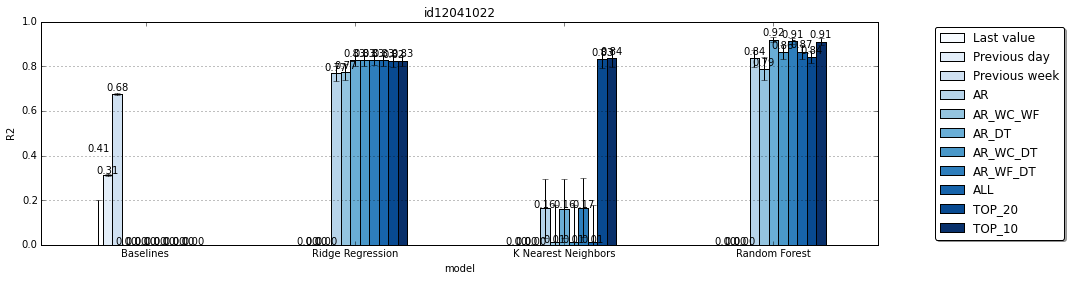

In [22]:
for sensor_id in validation_df.columns.levels[0]:
        
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
            
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel('R2')
    plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [388]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

'\nfor sensor_id in validation_df.columns.levels[0]:\n    ax = validation_df.loc[20][sensor_id][\'R2\'].unstack(0).plot(\n        kind=\'bar\', figsize=(15,4), rot=0, title=sensor_id, colormap=\'Blues\', ylim=(0,1))\n    \n    for p in ax.patches:\n        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha=\'center\')\n    \n    plt.gca().yaxis.grid(True)\n    ax.set_ylabel(measure)\n    plt.legend(loc=\'right\', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)\n'

## Evaluation Scores for Each Horizon

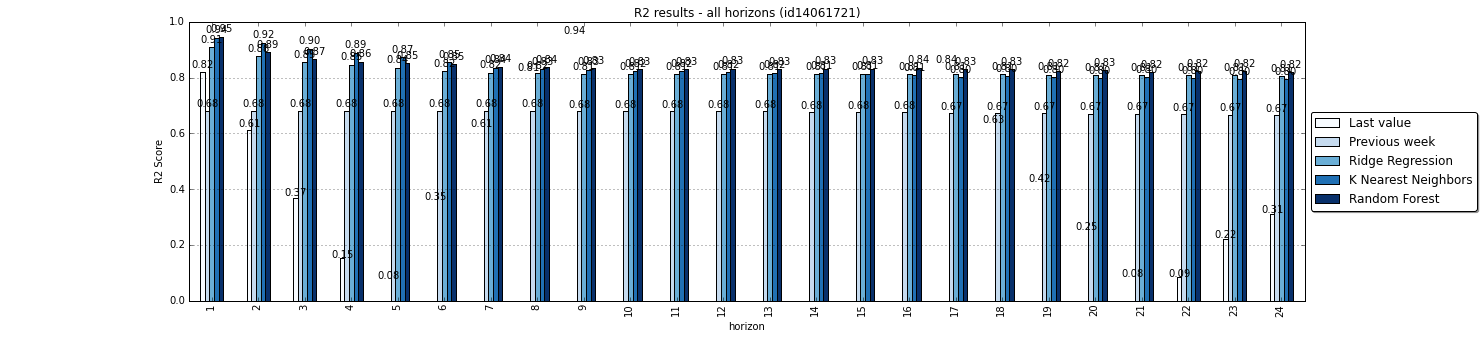

In [23]:
ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id12041022']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id12041022']['R2']).plot(
    kind='bar', figsize=(20,5), title='R2 results - all horizons (id14061721)', ylim=(0,1), colormap='Blues')

for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')

ax.yaxis.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.), ncol=5, fancybox=True, shadow=True)
#plt.legend(loc=4)
plt.ylabel('R2 Score')

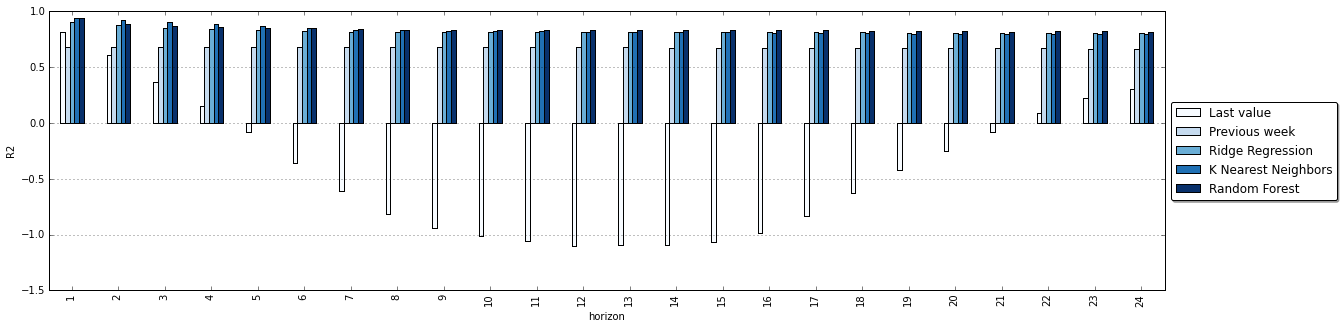

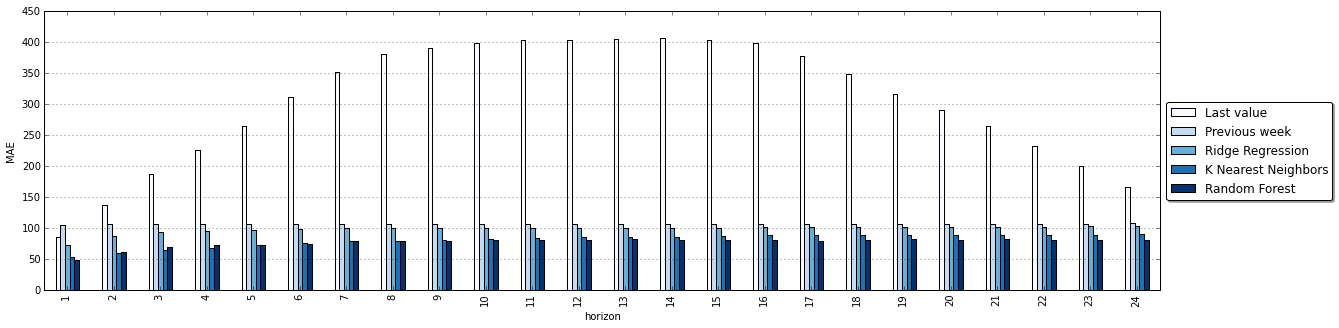

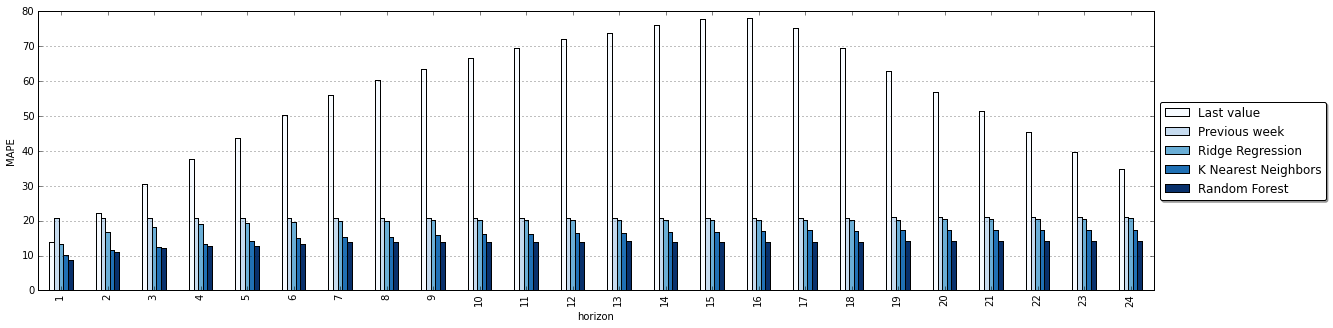

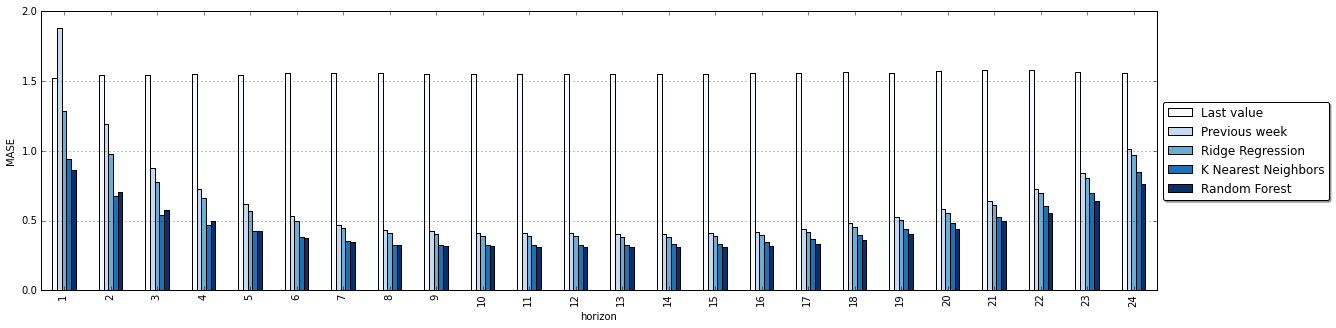

In [24]:
for measure in validation_df.columns.levels[1]:
    
    ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id12041022'][measure][['Last value', 'Previous week']].join(
        validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id12041022'][measure]).plot(
        kind='bar', figsize=(20,5), colormap='Blues')
    
    ax.yaxis.grid()   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
    plt.ylabel(measure)
 

## Average Score by Sensors and Horizons

In [16]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

error metric                                   R2       MAE       MAPE  \
dataset             model                                                
Last value          Baselines            0.561509  1.675817  29.038490   
Previous day        Baselines            0.399188  2.035682  41.442958   
Previous week       Baselines            0.655598  1.569669  30.650789   
Measurement average Baselines            0.176525  3.042106  72.821162   
AR                  Ridge Regression     0.812825  1.276349  27.640770   
                    K Nearest Neighbors  0.785566  1.356553  29.801900   
                    Random Forest        0.823768  1.255085  29.553442   
SELECTED            Ridge Regression     0.755056  1.611357  39.967885   
                    K Nearest Neighbors  0.781093  1.401275  30.995457   
                    Random Forest        0.842835  1.194789  26.340880   

error metric                                 MASE  
dataset             model                          
Last value          Baselines            0.728761  
Previous day        Baselines            0.939339  
Previous week       Baselines            0.724327  
Measurement average Baselines            1.378100  
AR                  Ridge Regression     0.575318  
                    K Nearest Neighbors  0.616033  
                    Random Forest        0.565061  
SELECTED            Ridge Regression     0.711889  
                    K Nearest Neighbors  0.631593  
                    Random Forest        0.538496

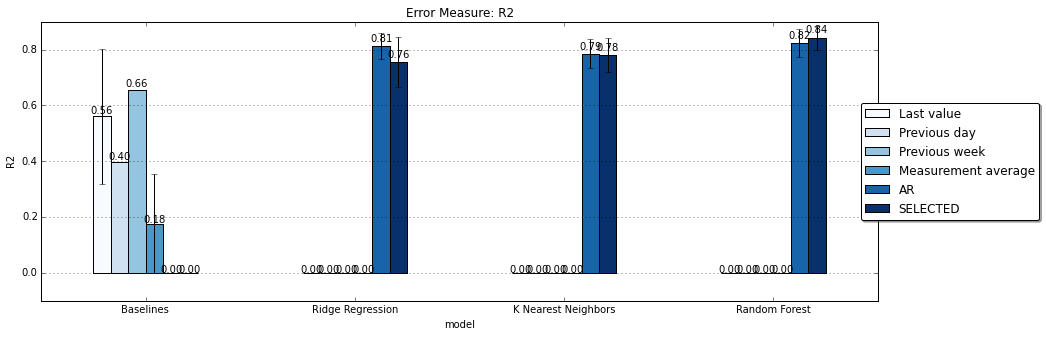

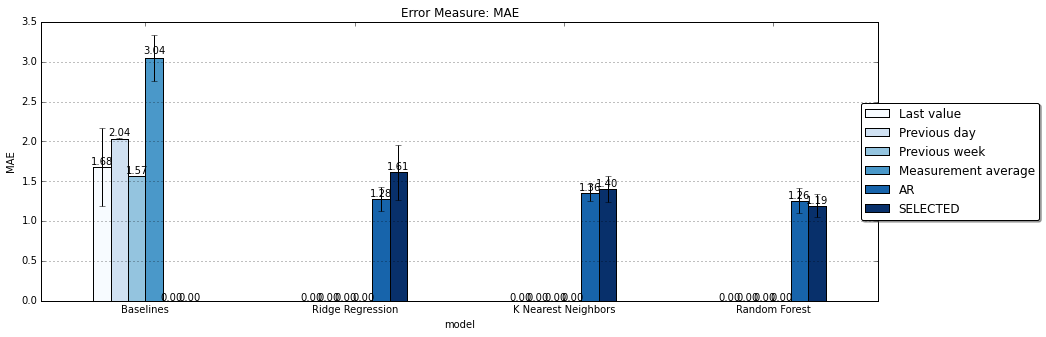

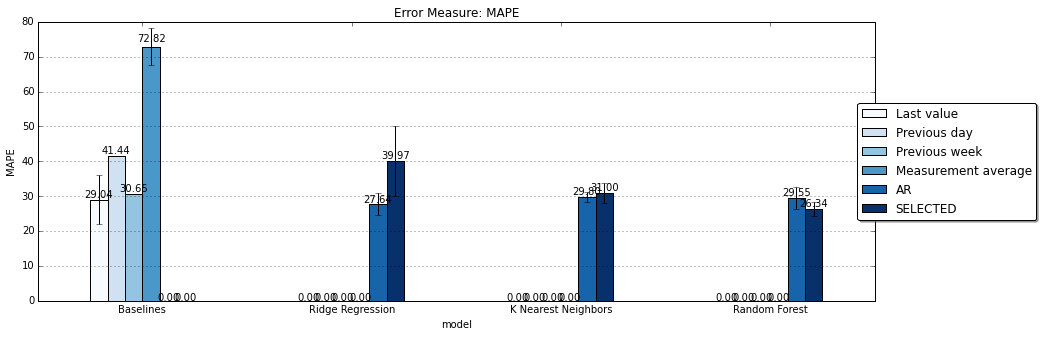

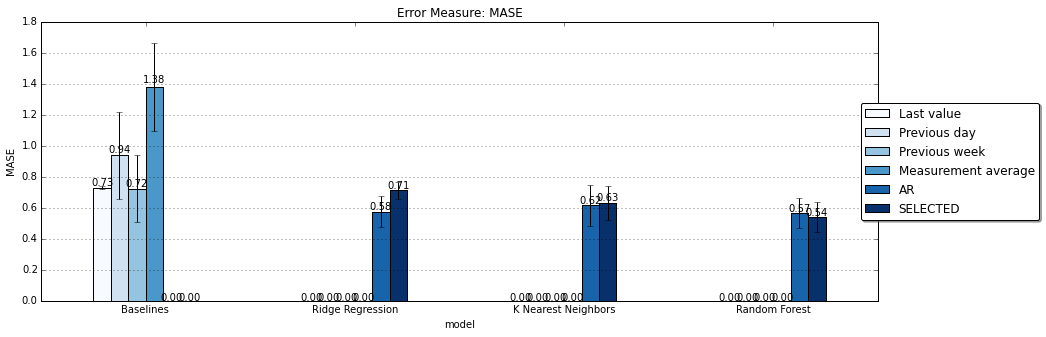

In [18]:
for measure in validation_df.columns.levels[1]:

    err = ax = validation_df.groupby(level=['dataset', 'model']).std().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.